In [43]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import *
from sklearn.model_selection import *

import keras
from keras.layers import *
from keras.callbacks import *
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM

from keras import initializers, regularizers, constraints, optimizers, layers

In [44]:
X_train =pd.read_csv('dataset_kaggle/X_train.csv')

In [45]:
X_test = pd.read_csv('dataset_kaggle/X_test.csv')

In [46]:
y_train = pd.read_csv("dataset_kaggle/y_train.csv")
sub = pd.read_csv("dataset_kaggle/sample_submission.csv")


In [47]:
X_train.tail()


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.14274,3.27180,2.0115,-9.0063
487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.13238,4.42750,3.0696,-8.1257
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.13894,2.70480,4.2622,-8.1443
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.13021,2.54100,4.7130,-9.4435
487679,3809_127,3809,127,0.62915,-0.76839,-0.084441,0.081284,-0.042769,0.034049,-0.12580,0.82391,4.2751,-10.4980


In [48]:
X_test.tail()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
488443,3815_123,3815,123,-0.96683,0.20760,0.021964,-0.14715,-0.000390,-0.21457,0.57327,1.11380,3.9277,-9.0971
488444,3815_124,3815,124,-0.96668,0.20832,0.022090,-0.14712,-0.001529,-0.18984,0.56691,0.22492,3.4683,-9.4288
488445,3815_125,3815,125,-0.96653,0.20902,0.022185,-0.14713,0.001642,-0.16331,0.56650,0.66608,3.6620,-8.9208
488446,3815_126,3815,126,-0.96637,0.20974,0.022284,-0.14710,-0.000159,-0.16968,0.57515,0.37295,3.5197,-8.4622
488447,3815_127,3815,127,-0.96621,0.21048,0.022436,-0.14709,-0.023368,-0.20818,0.57540,0.40491,3.6126,-8.5836


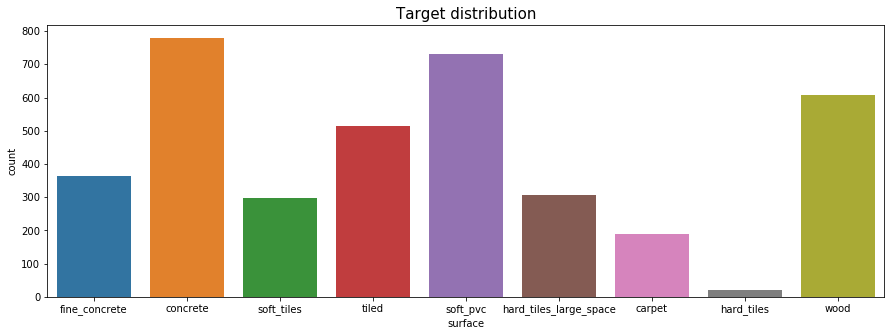

In [49]:
plt.figure(figsize = (15, 5))
sns.countplot(y_train['surface'])
plt.title('Target distribution', size = 15)
plt.show()

In [50]:
X_train.drop(['row_id', "series_id", "measurement_number"], axis=1, inplace=True)
X_train =X_train.values.reshape((3810, 128, 10))

In [51]:
X_test.drop(['row_id', 'series_id', 'measurement_number'], axis = 1, inplace = True)
X_test =X_test.values.reshape((3816, 128, 10))

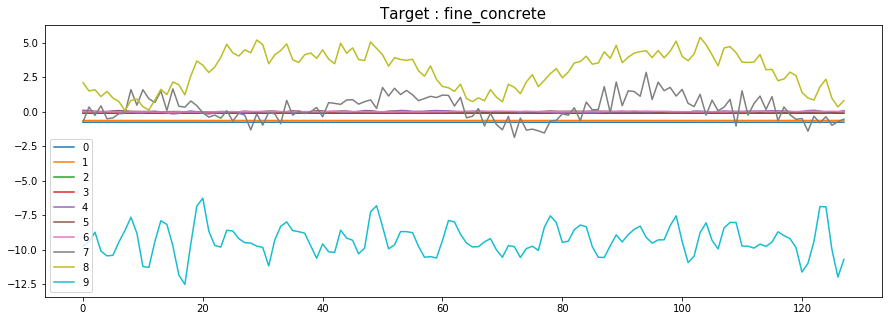

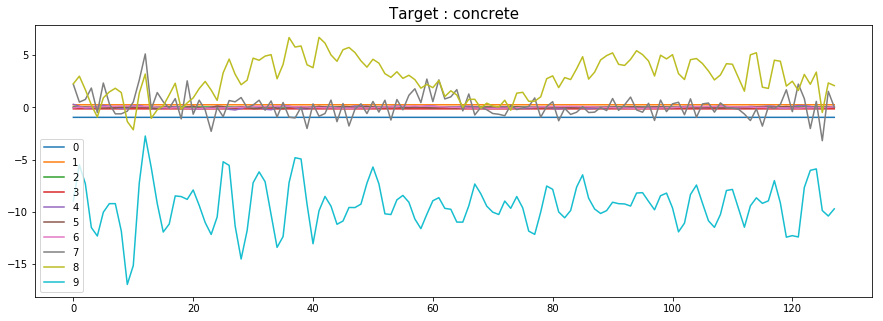

In [52]:
for j in range(2):
    plt.figure(figsize=(15, 5))
    plt.title("Target : " + y_train['surface'][j], size=15)
    for i in range(10):
        plt.plot(X_train[j, :, i], label=i)
    plt.legend()
    plt.show()
    

In [53]:
encode_dic = {'fine_concrete': 0, 
              'concrete': 1, 
              'soft_tiles': 2, 
              'tiled': 3, 
              'soft_pvc': 4,
              'hard_tiles_large_space': 5, 
              'carpet': 6, 
              'hard_tiles': 7, 
              'wood': 8}

In [54]:
decode_dic = {0: 'fine_concrete',
              1: 'concrete',
              2: 'soft_tiles',
              3: 'tiled',
              4: 'soft_pvc',
              5: 'hard_tiles_large_space',
              6: 'carpet',
              7: 'hard_tiles',
              8: 'wood'}

In [55]:
y_train = y_train['surface'].map(encode_dic).astype(int)

In [56]:
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],), initializer=self.init, name='{}_W'.format(self.name), regularizer=self.W_regularizer, constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],), initializer='zero', name='{}_b'.format(self.name), regularizer=self.b_regularizer, constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias: eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None: a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [60]:
def make_model():
    inp = Input(shape=(128, 10))
    x = Bidirectional(LSTM(32, return_sequences=True))(inp)
    x = Attention(128)(x)
    x = Dense(9, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [61]:
def k_folds(X, y, X_test, k=5):
    folds = list(StratifiedKFold(n_splits=k).split(X, y))
    y_test = np.zeros((X_test.shape[0], 9))
    y_oof = np.zeros((X.shape[0]))
    
    for i, (train_idx, val_idx) in  enumerate(folds):
        print(f"Fold {i+1}")
        model = make_model()
        model.fit(X[train_idx], y[train_idx], batch_size=64, epochs=75, 
                  validation_data=[X[val_idx], y[val_idx]], verbose=0)
        
        pred_val = np.argmax(model.predict(X[val_idx]), axis=1)
        score = accuracy_score(pred_val, y[val_idx])
        y_oof[val_idx] = pred_val
        
        print(f'Scored {score:.3f} on validation data')
        
        y_test += model.predict(X_test)
        
    return y_oof, y_test   

In [62]:
y_oof, y_test = k_folds(X_train, y_train, X_test, k=5)


Fold 1
Scored 0.554 on validation data
Fold 2
Scored 0.650 on validation data
Fold 3
Scored 0.677 on validation data
Fold 4
Scored 0.708 on validation data
Fold 5
Scored 0.713 on validation data


In [63]:
print(f'Local CV is {accuracy_score(y_oof, y_train): .4f}')

Local CV is  0.6601


In [65]:
def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

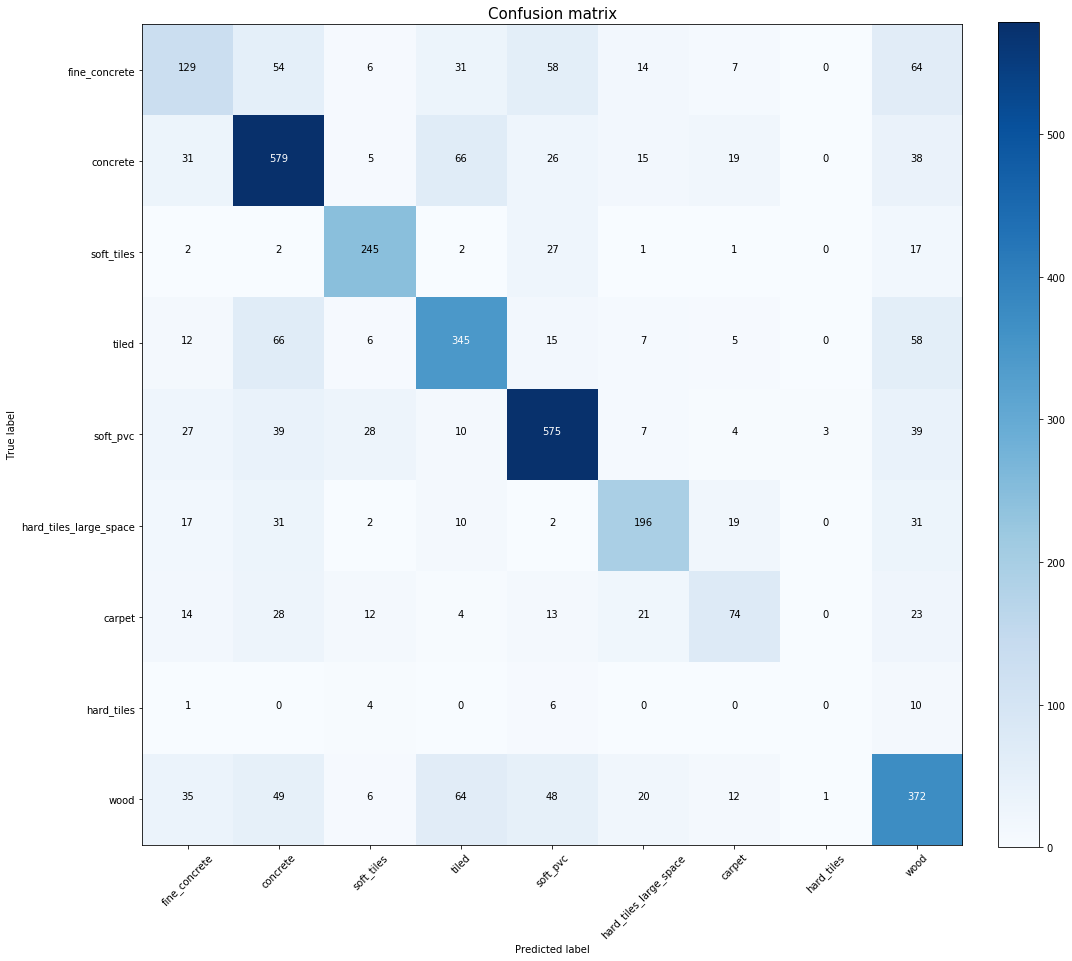

In [66]:
plot_confusion_matrix(y_train, y_oof, encode_dic.keys())


In [67]:
y_test = np.argmax(y_test, axis=1)


In [68]:
sub['surface'] = y_test
sub['surface'] = sub['surface'].map(decode_dic)
sub.head()


,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,wood
4,4,soft_pvc
